In [1]:
!pip install tensorflow datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Importing Libraries
from datasets import load_dataset
from tensorflow.keras.layers import (
    Input, Embedding, Dense, LSTM, Dropout, Bidirectional, Concatenate,
    MultiHeadAttention, GlobalMaxPooling1D, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np

In [3]:
# Enable mixed precision (Optional but beneficial for modern GPUs)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("No GPU found. Please enable GPU acceleration.")

Num GPUs Available:  1
TensorFlow is using the GPU.


In [4]:
# Download Fasttext embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz


--2024-12-10 01:10:03--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.121, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  23.5MB/s    in 54s     

2024-12-10 01:10:58 (23.4 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [5]:
# Load the SQuAD dataset
squad_2 = load_dataset('squad_v2')
train_data = squad_2['train']
val_data = squad_2['validation']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [6]:
# Initialize Tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
all_texts = (
    [example['context'] for example in train_data] +
    [example['question'] for example in train_data] +
    [answer for example in train_data for answer in example['answers']['text']]
)
tokenizer.fit_on_texts(all_texts)
vocab_size = len(tokenizer.word_index) + 1

In [7]:
# Parameters
max_context_len = 400
max_question_len = 50
embedding_dim = 300
hidden_size = 256
dropout_rate = 0.5
regularization_factor = 1e-4

In [8]:
# Load FastText embeddings into a dictionary
embedding_index = {}
fasttext_file = 'cc.en.300.vec'
with open(fasttext_file, 'r', encoding='utf8') as f:
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f'Loaded {len(embedding_index)} FastText word vectors.')

Loaded 2000000 FastText word vectors.


In [9]:
# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(f'Created embedding matrix with shape {embedding_matrix.shape}')

Created embedding matrix with shape (94578, 300)


In [10]:
# Preprocessing function
def preprocess_example(example):
    context_tokens = tokenizer.texts_to_sequences([example['context']])[0][:max_context_len]
    question_tokens = tokenizer.texts_to_sequences([example['question']])[0][:max_question_len]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')[0]
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')[0]

    start_labels = np.zeros(max_context_len)
    end_labels = np.zeros(max_context_len)

    if not example.get('is_impossible', False) and example['answers']['text']:
        answer_text = example['answers']['text'][0]
        start_char = example['answers']['answer_start'][0]
        answer_tokens = tokenizer.texts_to_sequences([answer_text])[0]

        for idx in range(len(context_tokens) - len(answer_tokens) + 1):
            if context_tokens[idx:idx+len(answer_tokens)] == answer_tokens:
                start_labels[idx] = 1
                end_labels[idx + len(answer_tokens) - 1] = 1
                break

    return context_padded, question_padded, start_labels, end_labels

In [11]:
# Create dataset
def create_tf_dataset(data, batch_size):
    processed_data = []
    for example in data:
        processed_example = preprocess_example(example)
        if processed_example is not None:
            processed_data.append(processed_example)

    contexts = np.array([item[0] for item in processed_data])
    questions = np.array([item[1] for item in processed_data])
    start_labels = np.array([item[2] for item in processed_data])
    end_labels = np.array([item[3] for item in processed_data])

    dataset = tf.data.Dataset.from_tensor_slices((
        {'context_input': contexts, 'question_input': questions},
        {'start_position': start_labels, 'end_position': end_labels}
    ))
    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

batch_size = 16
train_dataset = create_tf_dataset(train_data.select(range(60000)), batch_size)
val_dataset = create_tf_dataset(val_data.select(range(11873)), batch_size)

In [12]:
# Define model
context_input = Input(shape=(max_context_len,), name="context_input")
question_input = Input(shape=(max_question_len,), name="question_input")

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False
)

context_embedded = embedding_layer(context_input)
question_embedded = embedding_layer(question_input)

context_lstm = Bidirectional(LSTM(hidden_size, return_sequences=True, kernel_regularizer=l2(regularization_factor)))(context_embedded)
question_lstm = Bidirectional(LSTM(hidden_size, return_sequences=True, kernel_regularizer=l2(regularization_factor)))(question_embedded)

multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=hidden_size)(context_lstm, question_lstm)
residual_attention = Add()([context_lstm, multi_head_attention])

combined = Concatenate()([context_lstm, residual_attention])
lstm_combined = LSTM(hidden_size, return_sequences=True, kernel_regularizer=l2(regularization_factor))(combined)
global_pooled = GlobalMaxPooling1D()(lstm_combined)

dropout = Dropout(dropout_rate)(global_pooled)

start_output = Dense(
    max_context_len,
    activation="softmax",
    name="start_position",
    kernel_regularizer=l2(regularization_factor)
)(dropout)

end_output = Dense(
    max_context_len,
    activation="softmax",
    name="end_position",
    kernel_regularizer=l2(regularization_factor)
)(dropout)

In [13]:
with tf.device('/GPU:0'):
  model = Model(inputs=[context_input, question_input], outputs=[start_output, end_output])

In [14]:

# Custom metrics (need to be adapted for mixed precision)
def exact_match(y_true, y_pred):
    y_pred_idx = tf.argmax(y_pred, axis=-1)
    y_true_idx = tf.argmax(y_true, axis=-1)
    matches = tf.cast(tf.equal(y_true_idx, y_pred_idx), dtype=tf.float32)
    return tf.reduce_mean(matches)

In [15]:
# Compile the model with tuned hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4) # Reduced learning rate for stability
if mixed_precision.global_policy().name == 'mixed_float16':
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss={'start_position': 'categorical_crossentropy', 'end_position': 'categorical_crossentropy'},
    metrics={'start_position': [exact_match], 'end_position': [exact_match]},
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("optimized_model.keras", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
]


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 400)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 300)        │     28,373,400 │ context_input[0][0],   │
│                           │                        │                │ question_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 400, 512)       │      1,140,736 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 512)        │      1,140,736 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 400, 512)       │      4,200,960 │ bidirectional[0][0],   │
│ (MultiHeadAttention)      │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 400, 512)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 400, 1024)      │              0 │ bidirectional[0][0],   │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 400, 256)       │      1,311,744 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ lstm_2[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ start_position (Dense)    │ (None, 400)            │        102,800 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ end_position (Dense)      │ (None, 400)            │        102,800 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,373,176 (138.75 MB)

 Trainable params: 7,999,776 (30.52 MB)

 Non-trainable params: 28,373,400 (108.24 MB)

In [ ]:
# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=8,
    callbacks=callbacks
)
# Save the model
model.save("optimized_qa_model.keras")

Epoch 1/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 281s 72ms/step - end_position_exact_match: 0.1134 - end_position_loss: 3.6380 - loss: 7.4699 - start_position_exact_match: 0.0118 - start_position_loss: 3.6531 - val_end_position_exact_match: 0.4468 - val_end_position_loss: 2.4346 - val_loss: 5.0170 - val_start_position_exact_match: 0.0080 - val_start_position_loss: 2.4569 - learning_rate: 3.0000e-04
Epoch 2/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 269s 72ms/step - end_position_exact_match: 0.1745 - end_position_loss: 3.5023 - loss: 7.1455 - start_position_exact_match: 0.0164 - start_position_loss: 3.5309 - val_end_position_exact_match: 0.4691 - val_end_position_loss: 2.4368 - val_loss: 4.9974 - val_start_position_exact_match: 0.0085 - val_start_position_loss: 2.4574 - learning_rate: 3.0000e-04
Epoch 3/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 269s 72ms/step - end_position_exact_match: 0.1698 - end_position_loss: 3.4745 - loss: 7.0704 - start_position_exact_match: 0.0220 - start_position_loss: 3.5019 - val_end_p

In [ ]:
# Example inference function
def preprocess_inference(context, question):
    context_tokens = tokenizer.texts_to_sequences([context])[0][:max_context_len]
    question_tokens = tokenizer.texts_to_sequences([question])[0][:max_question_len]

    context_padded = pad_sequences([context_tokens], maxlen=max_context_len, padding='post')
    question_padded = pad_sequences([question_tokens], maxlen=max_question_len, padding='post')

    return {'context_input': context_padded, 'question_input': question_padded}, context_tokens

def decode_answer(context_tokens, start_prob, end_prob):
    start_index = np.argmax(start_prob)
    end_index = np.argmax(end_prob)
    if end_index < start_index:
        end_index = start_index
    answer_tokens = context_tokens[start_index:end_index+1]
    answer_words = tokenizer.sequences_to_texts([answer_tokens])[0]
    return answer_words

# Test the model
context = "The Apollo program was the third United States human spaceflight program carried out by NASA, responsible for landing the first humans on the Moon from 1969 to 1972."
question = "What program was responsible for landing humans on the Moon?"

inputs, context_tokens = preprocess_inference(context, question)
start_prob, end_prob = model.predict(inputs)
answer = decode_answer(context_tokens, start_prob[0], end_prob[0])

print("Question:", question)
print("Answer:", answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Question: What program was responsible for landing humans on the Moon?
Answer: apollo


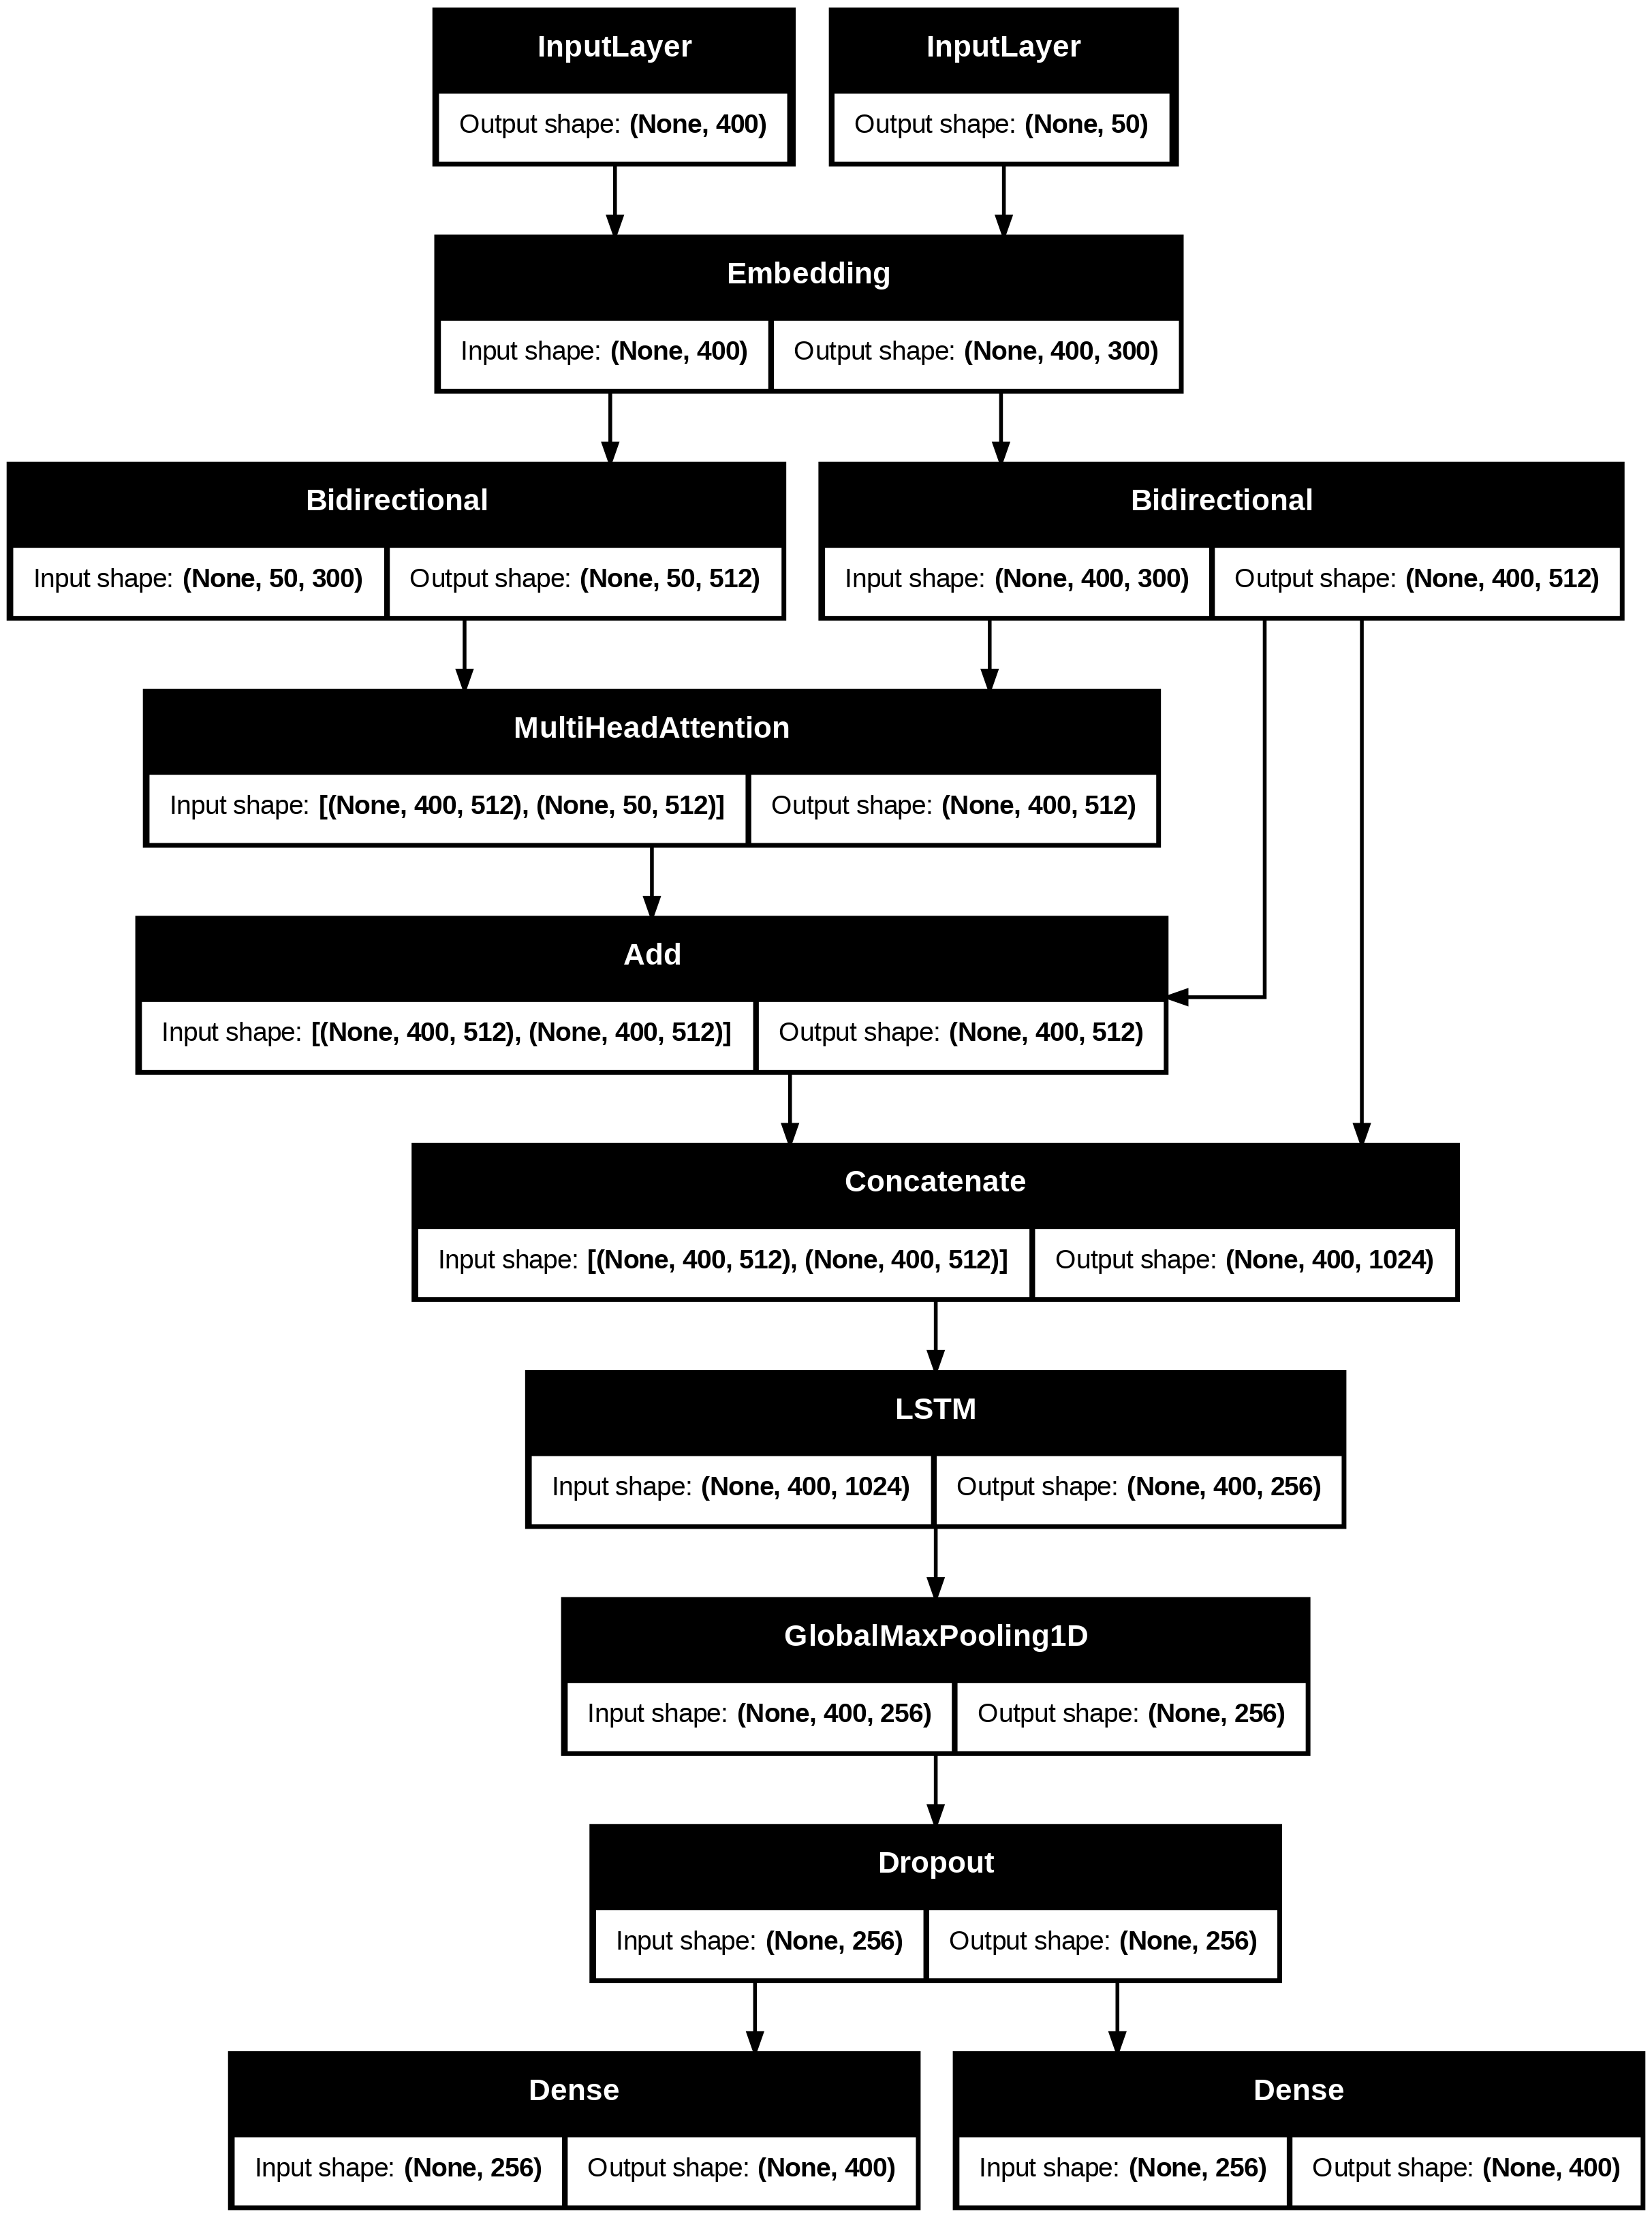

In [ ]:
# Visualize the model architecture (optional)
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)